# Определение перспективного тарифа для телеком компании

## Введение 
Федеральный оператор сотовой связи предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Для корректировки рекламного бюджета необходимо определить доходность тарифов для компании.
Требуется провести предварительный анализ тарифов на выборке из данных 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

Все значения минут и мегабайтов в тарифах округляются вверх (если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута).

# Описание данных
**Таблица users (информация о пользователях):**  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

**Таблица calls (информация о звонках):**  
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**  
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**  
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

**Таблица tariffs (информация о тарифах):**  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Открытие файла с данным и изучение общей информации

Импортируем необходимые для анализа библиотеки и откроем имеющиеся файлы с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим информацию в таблице calls, проверим число звонков с длительностью 0 минут.

In [2]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
print(
    f"Количество звонков с длительностью 0 минут равно {len(calls.query('duration == 0'))} или {len(calls.query('duration == 0'))/len(calls):.1%} от всех звонков"
)

Количество звонков с длительностью 0 минут равно 39613 или 19.6% от всех звонков


Изучим информацию в таблице internet, проверим число интернет-сессий с объемом трафика 0 Мбайт.

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
print(
    f"Количество интернет-сессий с объемом трафика 0 Мбайт равно {len(internet.query('mb_used == 0'))} или {len(internet.query('mb_used == 0'))/len(internet):.1%} от всех интернет-сессий"
)

Количество интернет-сессий с объемом трафика 0 Мбайт равно 19598 или 13.1% от всех интернет-сессий


Изучим информацию в таблице messages

In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Изучим информацию в таблице tariffs

In [10]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Изучим информацию в таблице users

In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

1) В таблице calls столбец 'call_date' потребуется привести к типу данных datetime, столбец	'duration' округлим в большую сторону и приведем к формату 'int'.  
2) В таблице internet столбец 'session_date' потребуется привести к типу данных datetime, столбец 'mb_used' округлим в большую сторону и приведем к формату 'int'. Столбец 'Unnamed: 0' удалим, так как в перечне описания столбцов этой таблицы он отсутствует и для анализа использоваться не будет. По всей видимости он дублирует индексы таблицы и возник из-за некорректной конвертации датасета из базы данных в .csv формат.  
3) В таблице messages столбец 'message_date' потребуется привести к типу данных datetime.  
4) В таблице users столбец 'churn_date' и 'reg_date' потребуется привести к типу данных datetime.  
5) В таблицах calls и internet в столбцах 'duration' и 'mb_used' соответственно, имеются данные с нулевыми значениями (19,6% и 13,1% соответственно). Вероятная причина появления этих данных - телефонные звонки без ответов и неуспешные попытки начать интернет-сессию, когда система зарегистрировала попытку, однако фактического потребления трафика по тарифному плану не было. Удалим эти значения, в связи с тем, что эти нулевые значения повлияют на исследуемые статистические величины (среднее, стандартное отклонение и тд.). 

## Подготовка данных

### Приведение данных к нужным типам

Приводим данные к типу datetime в соответствии с пунктом 1.1.

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Округляем данные в большую сторону и приводим данные к типу int в соответствии с пунктом 1.1. Для этого создадим функцию округления в большую сторону и пременим ее для каждой строки, после чего изменим тип данных на 'int'. 

In [15]:
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value).astype('int')  
internet['mb_used'] = internet['mb_used'].apply(ceil_value).astype('int')  

In [16]:
display(calls.dtypes)
display(internet.dtypes)
display(messages.dtypes)
display(users.dtypes)        

id                   object
call_date    datetime64[ns]
duration              int64
user_id               int64
dtype: object

Unnamed: 0               int64
id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

### Исправим ошибки в данных

В таблице internet удалим столбец 'Unnamed: 0' в соответствии с пунктом 1.1.

In [17]:
internet = internet.drop(['Unnamed: 0'], axis=1)

В таблицах calls и internet в столбцах 'duration' и 'mb_used' с помощью среза удалим нулевые значения в соответствии с пунктом 1.1. 

In [18]:
calls = calls.query('duration > 0')
internet = internet.query('mb_used > 0')

Для расчета по каждому пользователю количества сделанных звонков и израсходованных минут разговора по месяцам, количества отправленных сообщений по месяцам, объема израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя добавим в таблицы столбцы с месяцем пользования услугой.

In [19]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [20]:
display(calls.head())
display(internet.head())
display(messages.head())

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


### Посчитаем для каждого пользователя

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

Создадим сводную таблицу с длительностью разговоров и числом звонков для каждого пользователя по месяцам

In [21]:
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['sum', 'count'])
calls_pivot.columns = ['sum_calls', 'count_calls']
calls_pivot.head(20)

sum_calls  count_calls
user_id month                        
1000    5            159           17
        6            172           28
        7            340           41
        8            408           42
        9            466           46
        10           350           44
        11           338           37
        12           333           38
1001    11           430           45
        12           414           47
1002    6            117           14
        7            214           21
        8            289           37
        9            206           25
        10           212           24
        11           243           25
        12           236           27
1003    8            380           43
        9            961          105
        10           855           97

#### Количество отправленных сообщений по месяцам

Создадим сводную таблицу с числом отправленных сообщений для каждого пользователя по месяцам

In [22]:
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = ['count'])
messages_pivot.columns = ['count_messages']
messages_pivot.head(20)

count_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
        10                 73
        11                 58
        12                 70
1002    6                   4
        7                  11
        8                  13
        9                   4
        10                 10
        11                 16
        12                 12
1003    8                  37
        9                  91
        10                 83
        11                 94
        12                 75

#### Объем израсходованного интернет-трафика по месяцам

Создадим сводную таблицу с числом израсходованного инетрнет-трафика для каждого пользователя по месяцам

In [23]:
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = ['sum'])
internet_pivot.columns = ['mb_used_sum']
internet_pivot.head(20)

mb_used_sum
user_id month             
1000    5             2256
        6            23257
        7            14016
        8            14070
        9            14581
        10           14717
        11           14768
        12            9827
1001    11           18452
        12           14053
1002    6            10871
        7            17601
        8            20347
        9            16712
        10           13905
        11           18610
        12           18137
1003    8             8571
        9            12479
        10           14779

#### Помесячную выручку с каждого пользователя

Объедининим в таблицу user_pivot методом .join сводные таблицы по данным звонков, отправленных сообщений, интернет-трафика каждого пользователя по месяцам.

In [24]:
user_pivot = calls_pivot.join([messages_pivot, internet_pivot], how='outer')

Проверим и при необходимости сборосим индексы сводной таблицы user_pivot.

In [25]:
display(user_pivot.index.values) 
user_pivot = user_pivot.reset_index() 
display(user_pivot.index.values) 

array([(1000, 5), (1000, 6), (1000, 7), ..., (1499, 10), (1499, 11),
       (1499, 12)], dtype=object)

array([   0,    1,    2, ..., 3211, 3212, 3213])

Добавим к получившейся таблице тариф каждого пользователя. Кроме этого для дайнейшего анализа по каждому клиенту добавим возраст, дату подключения тарифа, дату прекращения тарифа (при наличии) и город.

In [26]:
user_pivot = user_pivot.merge(users[['user_id', 'tariff', 'age','reg_date', 'churn_date', 'city']], on='user_id', how='left')
user_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 11 columns):
user_id           3214 non-null int64
month             3214 non-null int64
sum_calls         3168 non-null float64
count_calls       3168 non-null float64
count_messages    2717 non-null float64
mb_used_sum       3201 non-null float64
tariff            3214 non-null object
age               3214 non-null int64
reg_date          3214 non-null datetime64[ns]
churn_date        187 non-null datetime64[ns]
city              3214 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 301.3+ KB


In [27]:
user_pivot.head(20)

,user_id,month,sum_calls,count_calls,count_messages,mb_used_sum,tariff,age,reg_date,churn_date,city
0,1000,5,159.0,17.0,22.0,2256.0,ultra,52,2018-05-25,NaT,Краснодар
1,1000,6,172.0,28.0,60.0,23257.0,ultra,52,2018-05-25,NaT,Краснодар
2,1000,7,340.0,41.0,75.0,14016.0,ultra,52,2018-05-25,NaT,Краснодар
3,1000,8,408.0,42.0,81.0,14070.0,ultra,52,2018-05-25,NaT,Краснодар
4,1000,9,466.0,46.0,57.0,14581.0,ultra,52,2018-05-25,NaT,Краснодар
5,1000,10,350.0,44.0,73.0,14717.0,ultra,52,2018-05-25,NaT,Краснодар
6,1000,11,338.0,37.0,58.0,14768.0,ultra,52,2018-05-25,NaT,Краснодар
7,1000,12,333.0,38.0,70.0,9827.0,ultra,52,2018-05-25,NaT,Краснодар
8,1001,11,430.0,45.0,NaN,18452.0,smart,41,2018-11-01,NaT,Москва
9,1001,12,414.0,47.0,NaN,14053.0,smart,41,2018-11-01,NaT,Москва


Переименуем столбец 'tariff_name' на 'tariff' в таблице tariffs, для последующего объединения с таблицей user_pivot.

In [28]:
tariffs.rename(columns = lambda x: x.replace('tariff_name', 'tariff'), inplace=True)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объединяем две таблицы по столбцу 'tariff'.

In [29]:
user_pivot = user_pivot.merge(tariffs, on='tariff', how='left') 

In [30]:
user_pivot.head(10)

,user_id,month,sum_calls,count_calls,count_messages,mb_used_sum,tariff,age,reg_date,churn_date,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17.0,22.0,2256.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28.0,60.0,23257.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41.0,75.0,14016.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42.0,81.0,14070.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46.0,57.0,14581.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
5,1000,10,350.0,44.0,73.0,14717.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
6,1000,11,338.0,37.0,58.0,14768.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
7,1000,12,333.0,38.0,70.0,9827.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
8,1001,11,430.0,45.0,NaN,18452.0,smart,41,2018-11-01,NaT,Москва,50,15360,500,550,200,3,3
9,1001,12,414.0,47.0,NaN,14053.0,smart,41,2018-11-01,NaT,Москва,50,15360,500,550,200,3,3


Так как таблица user_pivot отражает поведение клиентов за месяц и ранее были исключены случаи звонков длительностью 0 минут и интернет-сессии с расходом трафика 0 Мбайт, заполним пропуски в столбцах 'sum_calls', 'count_messages' и 'mb_used_sum' нулевыми значениями. Необработка пропусков приведет к искажению статистики (завышению среднего значения). Ситуации, когда пользователи на протияжении месяца не пользуются интернетом (клиеты не обладающие смартфонами), звонками (использоваие звонков в мессенджерах) или сообщениями (использование мессенджеров) вполне уместны и стоит их учитывать. 

In [31]:
user_pivot[['sum_calls', 'count_messages', 'mb_used_sum']] = user_pivot[['sum_calls', 'count_messages', 'mb_used_sum']].fillna(0)

In [32]:
user_pivot.head(10)

,user_id,month,sum_calls,count_calls,count_messages,mb_used_sum,tariff,age,reg_date,churn_date,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17.0,22.0,2256.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28.0,60.0,23257.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41.0,75.0,14016.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42.0,81.0,14070.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46.0,57.0,14581.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
5,1000,10,350.0,44.0,73.0,14717.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
6,1000,11,338.0,37.0,58.0,14768.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
7,1000,12,333.0,38.0,70.0,9827.0,ultra,52,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1
8,1001,11,430.0,45.0,0.0,18452.0,smart,41,2018-11-01,NaT,Москва,50,15360,500,550,200,3,3
9,1001,12,414.0,47.0,0.0,14053.0,smart,41,2018-11-01,NaT,Москва,50,15360,500,550,200,3,3


Для расчета помесячной выручки с каждого пользователя:  
- вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;  
- остаток умножим на значение из тарифного плана;  
- прибавим абонентскую плату, соответствующую тарифному плану.  
Добавим значение помесячной выручки с каждого пользователя с столбец revenue_per_month.

Объявляем функцию для расчета помесячной выручки с каждого пользователя.

In [33]:
def revenue_func(row):
    if row['sum_calls'] > row['minutes_included']:
        сalls_cost = (row['sum_calls'] - row['minutes_included']) * row['rub_per_minute']
    else:
        сalls_cost = 0
    if  row['count_messages'] > row['messages_included']:
        messages_cost = (row['count_messages'] - row['messages_included']) * row['rub_per_message']   
    else: 
        messages_cost = 0
    if row['mb_used_sum'] > row['mb_per_month_included']:
        gb_cost = (row['mb_used_sum'] - row['mb_per_month_included']) / 1024 * row['rub_per_gb']
    else:
        gb_cost = 0
    total_cost = row['rub_monthly_fee'] + сalls_cost + messages_cost + gb_cost
    return total_cost

Применяем функцию расчета помесячной выручки к строкам таблицы user_pivot, округляем и приводим к типу данных 'int' значение помесячной выручки.

In [34]:
user_pivot['revenue_per_month'] = user_pivot.apply(revenue_func, axis=1)
user_pivot['revenue_per_month'] = user_pivot['revenue_per_month'].apply(ceil_value).astype('int')

Выведем 20  строк наиболее интересующих столбцов.

In [35]:
user_pivot[['user_id', 'month', 'sum_calls','minutes_included', 'count_messages',
            'messages_included','mb_used_sum', 'mb_per_month_included','tariff', 'revenue_per_month']].head(20)

,user_id,month,sum_calls,minutes_included,count_messages,messages_included,mb_used_sum,mb_per_month_included,tariff,revenue_per_month
0,1000,5,159.0,3000,22.0,1000,2256.0,30720,ultra,1950
1,1000,6,172.0,3000,60.0,1000,23257.0,30720,ultra,1950
2,1000,7,340.0,3000,75.0,1000,14016.0,30720,ultra,1950
3,1000,8,408.0,3000,81.0,1000,14070.0,30720,ultra,1950
4,1000,9,466.0,3000,57.0,1000,14581.0,30720,ultra,1950
5,1000,10,350.0,3000,73.0,1000,14717.0,30720,ultra,1950
6,1000,11,338.0,3000,58.0,1000,14768.0,30720,ultra,1950
7,1000,12,333.0,3000,70.0,1000,9827.0,30720,ultra,1950
8,1001,11,430.0,500,0.0,50,18452.0,15360,smart,1154
9,1001,12,414.0,500,0.0,50,14053.0,15360,smart,550


Выведем описание столбца 'revenue_per_month' (помесячная выручка). 

In [36]:
user_pivot['revenue_per_month'].describe()

count    3214.000000
mean     1487.080274
std       784.043394
min       550.000000
25%       694.000000
50%      1563.500000
75%      1950.000000
max      6712.000000
Name: revenue_per_month, dtype: float64

### Вывод

1) Данные подготовлены в соответствии с пунктом 1.1.  

2) Для каждого пользователя добавлены необходимые для дальнейшего анализа параметры:  
- количество сделанных звонков и израсходованных минут разговора по месяцам;  
- количество отправленных сообщений по месяцам;  
- объем израсходованного интернет-трафика по месяцам;  
- помесячная выручка.

## Проанализируем данные



### Ответим на вопрос сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение.


По данным таблицы user_pivot создадим сводную таблицу tariff_pivot и посчитаем для каждого тарифа тарифа месячное потребление минут разговора (calls), сообщений (messages) и интернет-трафика в Мбайтах (mb_traffic). Выведем стреднее количество (mean), дисперсию (var) и стандартное отклонение (std).

In [37]:
tariff_pivot = user_pivot.pivot_table(
    index='tariff', values=['sum_calls', 'count_messages', 'mb_used_sum'], aggfunc=['mean', np.var, np.std]
)
tariff_pivot.columns = (
    ['mean_messages', 'mean_mb_traffic', 'mean_calls', 'var_messages','var_mb_traffic', 
     'var_calls', 'std_messages', 'std_mb_traffic', 'std_calls']
)
tariff_pivot = tariff_pivot.reset_index()
tariff_pivot

,tariff,mean_messages,mean_mb_traffic,mean_calls,var_messages,var_mb_traffic,var_calls,std_messages,std_mb_traffic,std_calls
0,smart,33.384029,16229.188425,417.934948,796.812958,3.454591e+07,36219.315784,28.227876,5877.576978,190.313730
1,ultra,49.363452,19486.901523,526.623350,2285.266143,1.019356e+08,100873.633397,47.804457,10096.317202,317.606098


### Построим гистограммы и опишем распределения.

Создадим таблицы с помесячным расходом минут разговора, числа сообщений, интернет-трафика пользователей каждого тарифа.

In [38]:
smart = user_pivot[user_pivot['tariff'] == 'smart']
ultra = user_pivot[user_pivot['tariff'] == 'ultra']

Построим гистограмму минут разговора в месяц пользотелей каждого тарифа.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

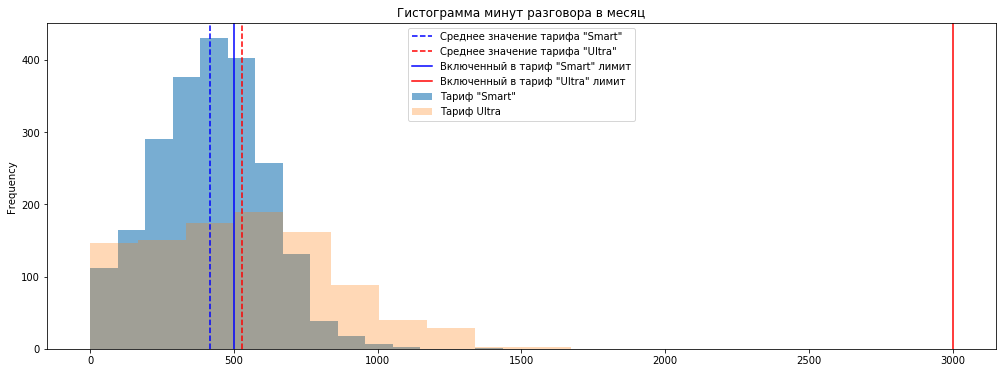

In [39]:
ax = smart['sum_calls'].plot(
    kind = 'hist', bins=15, figsize =(17, 6), alpha=0.6, grid = True, label='Тариф "Smart"'
)
ax = ultra['sum_calls'].plot(
    kind = 'hist', bins=10, alpha=0.3, label='Тариф Ultra'
)

plt.axvline(x=417.9, label='Среднее значение тарифа "Smart"', color='b', linestyle='--')
plt.axvline(x=526.6, label='Среднее значение тарифа "Ultra"', color='r', linestyle='--')
plt.axvline(x=500, label='Включенный в тариф "Smart" лимит', color='b', linestyle='-')
plt.axvline(x=3000, label='Включенный в тариф "Ultra" лимит', color='r', linestyle='-')

ax.set_title('Гистограмма минут разговора в месяц')
plt.legend()
plt.plot

Построим гистограмму количества сообщений в месяц пользотелей каждого тарифа.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

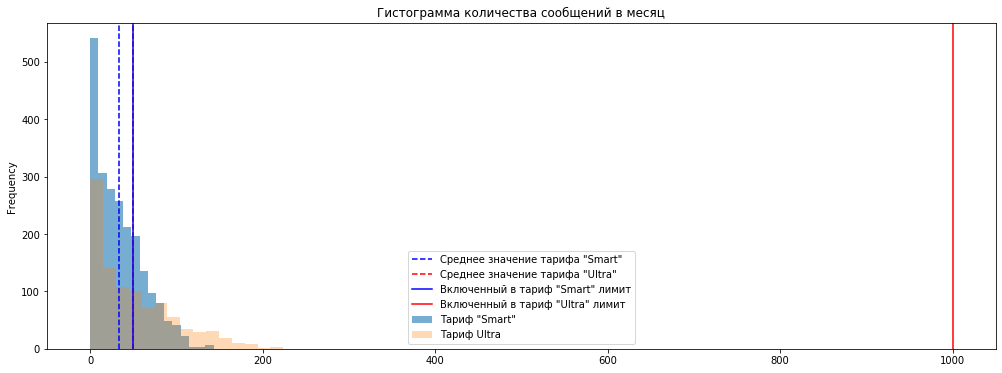

In [40]:
ax = smart['count_messages'].plot(
    kind = 'hist', bins=15, figsize =(17, 6), alpha=0.6, grid = True, label='Тариф "Smart"'
)
ax = ultra['count_messages'].plot(
    kind = 'hist', bins=15, alpha=0.3, label='Тариф Ultra'
)

plt.axvline(x=33.4, label='Среднее значение тарифа "Smart"', color='b', linestyle='--')
plt.axvline(x=49.4, label='Среднее значение тарифа "Ultra"', color='r', linestyle='--')
plt.axvline(x=50, label='Включенный в тариф "Smart" лимит', color='b', linestyle='-')
plt.axvline(x=1000, label='Включенный в тариф "Ultra" лимит', color='r', linestyle='-')

ax.set_title('Гистограмма количества сообщений в месяц')
plt.legend()
plt.plot

Построим гистограмму потребеления интернет-траффика в месяц пользотелей каждого тарифа.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

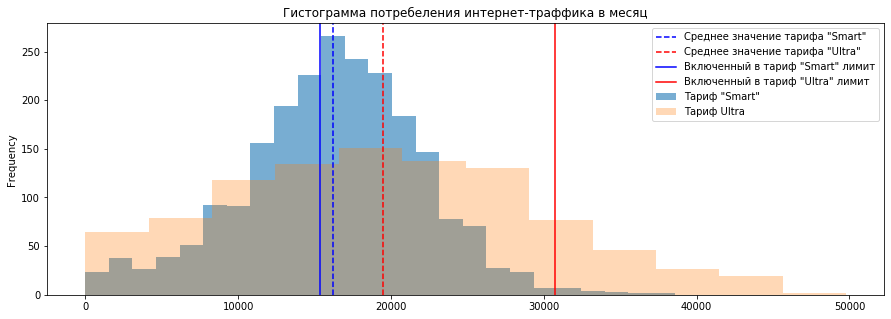

In [41]:
ax = smart['mb_used_sum'].plot(
    kind = 'hist', bins=25, figsize =(15, 5), alpha=0.6, grid = True, label='Тариф "Smart"'
)
ax = ultra['mb_used_sum'].plot(
    kind = 'hist', bins=12, alpha=0.3, label='Тариф Ultra'
)

plt.axvline(x=16229.2, label='Среднее значение тарифа "Smart"', color='b', linestyle='--')
plt.axvline(x=19486.9, label='Среднее значение тарифа "Ultra"', color='r', linestyle='--')
plt.axvline(x=15360, label='Включенный в тариф "Smart" лимит', color='b', linestyle='-')
plt.axvline(x=30720, label='Включенный в тариф "Ultra" лимит', color='r', linestyle='-')

ax.set_title('Гистограмма потребеления интернет-траффика в месяц')
plt.legend()
plt.plot

### Вывод

По результатам анализа пользователям тарифа "smart" / "ultra" ежемесячно требуется:

417,9 / 526,6 минут разговора, при стандатрном отклонении 190,3 / 317,6 минут и диспресии 36219,3 / 100873,6;  
33,4 / 49,4 сообщений, при стандартном отклонении 28,2 / 47,8 сообщений и диспресии 796,8 / 2285,3;  
16229,2 / 19486,9 Мбайт интернет-трафика, при стандартном отклонении 5877,6 / 10096,3 Мбайт и дисперсии 3,45×10^7 / 1.02×10^8.  

**Описание гистограмм распределения:**  
- **Тариф "smart"**  
1.1. Распределение минут разговора - нормальное. Данные почти симетрично расположены около среднего 417,9 минут. При этом стоит отметить, что включенный в абонентскую плату лимит минут (500) находится близко к среднему значению расхода минут. Таким образом значимая часть клинетов не укладывается в тарифный лимит и возможно задумается о его смене.  
1.2. Распределение числа сообщений - с положительной скошенностью. 25% клиентов отправляют не более 10 сообщений в месяц. Лимит сообщений (50) выше среднего значения (33,4) отправляемых сообщений менее, чем на одно стандартное отклонение (28,2). 75% пользоватлей отправляют не более 51 сообщения в месяц.  
1.3. Распределение интернет-трафика - нормальное. Данные почти симетрично расположены около среднего 16229 Мбайт. Включенный в абонентскую плату лимит (15360 Мбайт) меньше среднего значения. Половина пользователей (по медианному значению) расходуют более 16531 Мбайта ежемесячно. Включенный абонентский лимит нуждается в корректировке, так как не удовлетворяет нуждам клиентов.  


- **Тариф "ultra"**  
2.1. Распределение минут разговора в месяц для тарифа "ultra" - с положительной скошенностью. При этом включенный в абонентскую плату лимит минут (3000) находится на расстоянии более трёх сигм (стандартное отклонение 317,6) от среднего значения (526,6). Максимальная длительность минут разговора в месяц по имеющимся данным 1673 минуты. Таким образом пользователи не нуждаются в предоставленном лимите, и возможно задумаются о переходе на тариф с меньшим лимитом и абонентской платой.  
2.2. Распределение числа сообщений - с положительной скошенностью. 25% клиентов оптравляют не более 6 сообщений в месяц. Ни один пользователь выборки не отправил более 224 сообщений в месяц, при включенном в абонентскую плату лимите в 1000 сообщений, следовательно возможна корректировка лимита в меньшую сторону.  
2.3. Распределение интернет-трафика - нормальное с небольшой положительной скошенностью. Данные почти симетрично расположены окло среднего 19486,9 Мбайт. Включенный в абонентскую плату лимит инетрент-траффика (30720) находится на расстоянии одной сигмы (10096) от среднего значения. Более 75% клиентов тарифа укладываются в тарифный лимит. Максимальное потребление интернет-трафика в выборке составило 49789 Мбайт.  

## Проверим гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Создадим выборки месячной прибыли пользователей каждого тарифа и зададим параметр alpha (критический уровень статистической значимости) 0,05.

In [42]:
smart_revenue = smart['revenue_per_month']
ultra_revenue = ultra['revenue_per_month']
alpha = 0.05

Сформируем **нулевую гипотезу**: средняя выручка пользовтелей тарифов "Ультра" и "Смарт" **не различается**.  
**Альтернативной гипотезой** будет: средняя выручка пользовтелей тарифов "Ультра" и "Смарт" **различается**.  
Проверим гипотезу о равенстве средних двух генеральных совокупнойстей для парных выборок. Дисперсии выборок будем считать не равными.

In [43]:
results = st.ttest_ind(smart_revenue, ultra_revenue, equal_var = False)

print('Средняя выручка тарифа smart', smart_revenue.mean())
print('Средняя выручка тарифа ultra', ultra_revenue.mean())
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка тарифа smart 1233.641094661283
Средняя выручка тарифа ultra 2060.5989847715737
p-значение:  1.620572799195892e-295
Отвергаем нулевую гипотезу


### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Создадим выборки средней выручки в месяц пользователей из Москвы и пользователей из других городов и зададим параметр alpha (критический уровень статистической значимости) 0,05.

In [44]:
moscow_revenue = user_pivot.query('city == "Москва"')['revenue_per_month']
other_city_revenue = user_pivot.query('city != "Москва"')['revenue_per_month']
alpha = 0.05

Сформируем **нулевую гипотезу**: выручка пользователей тарифов пользователей из Москвы **не отличается** от средней выручки пользователей из других регионов.  
**Альтернативной гипотезой** будет: выручка пользователей тарифов пользователей из Москвы **отличается** от средней выручки пользователей из других регионов.  
Проверим гипотезу о равенстве средних двух генеральных совокупнойстей для парных выборок. Дисперсии выборок будем считать не равными.

In [45]:
results = st.ttest_ind(moscow_revenue, other_city_revenue)

print('Средняя выручка пользователей из Москве', moscow_revenue.mean())
print('Средняя пвыручка пользователей из других городов', other_city_revenue.mean())
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка пользователей из Москве 1507.4828150572832
Средняя пвыручка пользователей из других городов 1482.2912024587015
p-значение:  0.4748527079597812
Не получилось отвергнуть нулевую гипотезу


### Вывод

#### Средняя выручка пользователей тарифов "Ультра" и "Смарт"

**Нулевая гипотеза** о том, что средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается **отвеграется**.  

Следовательно **альтернативная гипотеза**, что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается **не отвергается**.

#### Средняя выручка пользователей из Москвы и пользователей из других городов

**Нулевую гипотезу** о том, что выручка пользователей из Москвы не отличается от средней выручки пользователей из других городов **отвергнуть не удалось**.

## Итоговый вывод

Проведен предварительный анализ тарифов "Смарт" и "Ультра" на выборке из данных 500 пользователей. В ходе анализа выполнены:  
- Изучение общей информации предоставленных данных;  
- Подготовка данных и добавлены необходимые параметры для каждого пользователя (количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячная выручка);  
По результатам анализа пользователям тарифа "smart" / "ultra" ежемесячно требуется:  
417,9 / 526,6 минут разговора, при стандатрном отклонении 190,3 / 317,6 минут и дисперсии 36219,3 / 100873,6;  
33,4 / 49,4 сообщений, при стандартном отклонении 28,2 / 47,8 сообщений и дисперсии 796,8 / 2285,3;  
16229,2 / 19486,9 Мбайт интернет-трафика, при стандартном отклонении 5877,6 / 10096,3 Мбайт и дисперсии 3,45×10^7 / 1.02×10^8.
- Анализ тарифов  
**Тариф "smart"**  
1.1. Включенный в абонентскую плату лимит минут (500) находится близко к среднему значению расхода минут (417,9). Таким образом значимая часть клинетов не укладывается в тарифный лимит и возможно задумается о его смене. Рекомендуется рассмотреть возможность увеличения лимита минут. 
1.2. Лимит сообщений (50) выше среднего значения отправляемых сообщений (33,4), при этом 75% пользоватлей отправляют не более 51 сообщения в месяц.  
1.3. Включенный в абонентскую плату лимит инетрнет-трафика - 15360 Мбайт меньше среднего значения - 16229 Мбайт. Половина пользователей (по медианному значению) расходуют более 16531 Мбайта ежемесячно. Включенный абонентский лимит нуждается в корректировке, так как не удовлетворяет нуждам клиентов. Рекомендуется рассмотреть возможность увеличения лимита интернет-трафика. 
**Тариф "ultra"**  
2.1. Включенный в абонентскую плату лимит минут (3000) находится на расстоянии более трёх сигм (стандартное отклонение 317,6) от среднего значения (526,6). Максимальная длительность минут разговора в месяц по имеющимся данным 1673 минуты. Таким образом пользователи не нуждаются в предоставленном лимите и возможна корректировка включенного в абнонентскую плату лимита минут до 1479 минут (среднего значения плюс три стандартных отклонения).  
2.2. Ни один пользователь выборки не отправил более 224 сообщений в месяц, при включенном в абонентскую плату лимите в 1000 сообщений, следовательно возможна корректировка лимита в меньшую сторону.  
2.3. Среднее потребление интернет-трафика 19486,9 Мбайт. Включенный в абонентскую плату лимит инетрент-траффика (30720) находится на расстоянии одной сигмы (10096) от среднего значения. Более 75% клиентов тарифа укладываются в тарифный лимит. Максимальное потребление интернет-трафика в выборке составило 49789 Мбайт.  
- Гипотезу: средняя выручка пользователей тарифов "Ультра" и "Смарт" различается **отвергнуть не удалось** при критическом уровне статистической значимости 5%;  
Средняя выручка тарифа smart 1233.64,  
Средняя выручка тарифа ultra 2060.59,
- Гипотезу: средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других городов **удалось отвергнуть** при критическом уровне статистической значимости 5%.  
Средняя выручка пользователей из Москве 1507.48,  
Средняя пвыручка пользователей из других городов 1482.29.
